In [ ]:
# Step 1: Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Step 2: Install necessary packages
!pip install wordcloud nltk seaborn matplotlib scikit-learn --quiet

# Step 3: Load the dataset
url = "/content/sentiment.csv"  # Replace with actual CSV file path
df = pd.read_csv(url)

# Step 4: Basic Exploration
print("Initial Shape:", df.shape)
df = df[['Text', 'Sentiment']]  # Selecting only relevant columns
df.dropna(inplace=True)  # Remove rows with missing values
df.drop_duplicates(inplace=True)

# Step 5: Text Cleaning
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", '', text)  # Remove special characters and punctuation
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

# Apply cleaning function
df['Clean_Text'] = df['Text'].apply(clean_text)

# Remove emojis (non-ASCII characters)
df['Clean_Text'] = df['Clean_Text'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))  # Remove emojis

# Step 6: Encode Sentiment Labels
label_encoder = LabelEncoder()
df['Encoded_Sentiment'] = label_encoder.fit_transform(df['Sentiment'])

# Step 7: Preview Cleaned Data
print("Cleaned Shape:", df.shape)
df.head()

Initial Shape: (732, 15)
Cleaned Shape: (708, 4)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Text,Sentiment,Clean_Text,Encoded_Sentiment
0,Enjoying a beautiful day at the park! ...,Positive,enjoying beautiful day park,214
1,Traffic was terrible this morning. ...,Negative,traffic terrible morning,195
2,Just finished an amazing workout! 💪 ...,Positive,finished amazing workout,214
3,Excited about the upcoming weekend getaway! ...,Positive,excited upcoming weekend getaway,214
4,Trying out a new recipe for dinner tonight. ...,Neutral,trying new recipe dinner tonight,197


<ipython-input-14-667188751fff>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_top, x='Sentiment', palette='Set2', order=top_emotions)


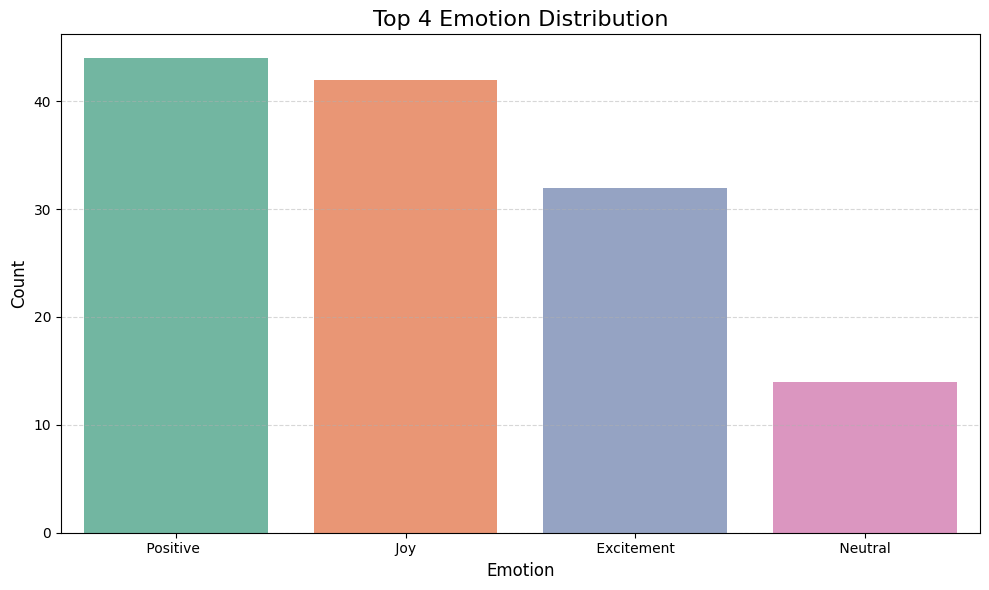

<ipython-input-14-667188751fff>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top, x='Sentiment', y='Text_Length', palette='Pastel1')


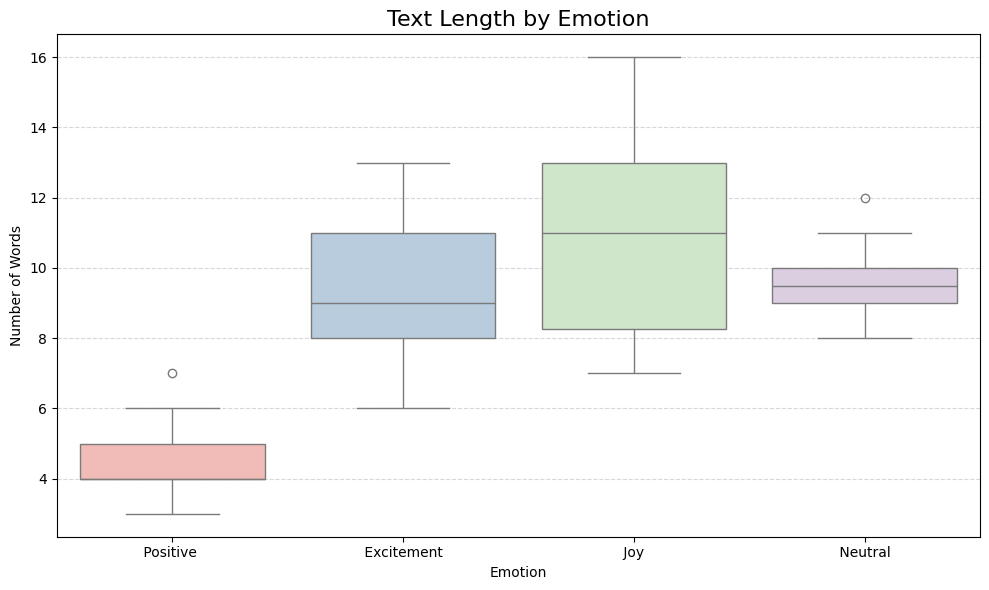

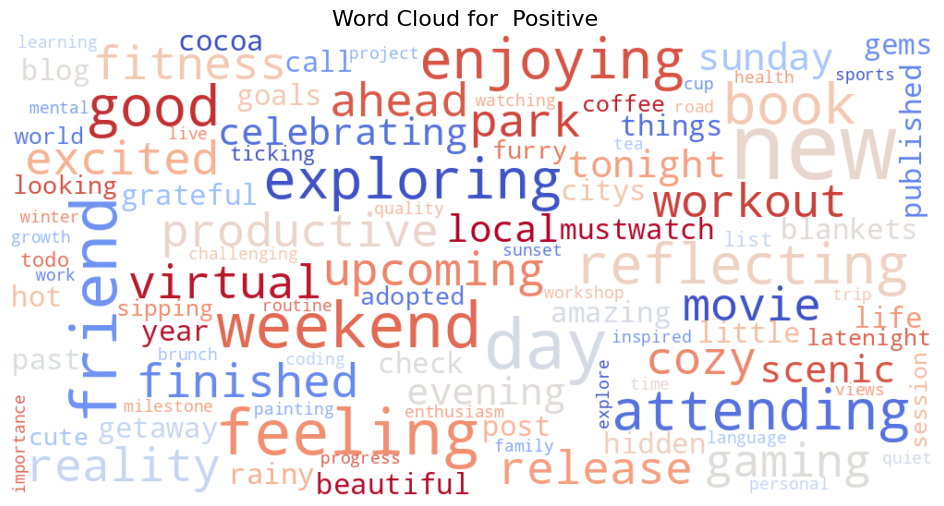

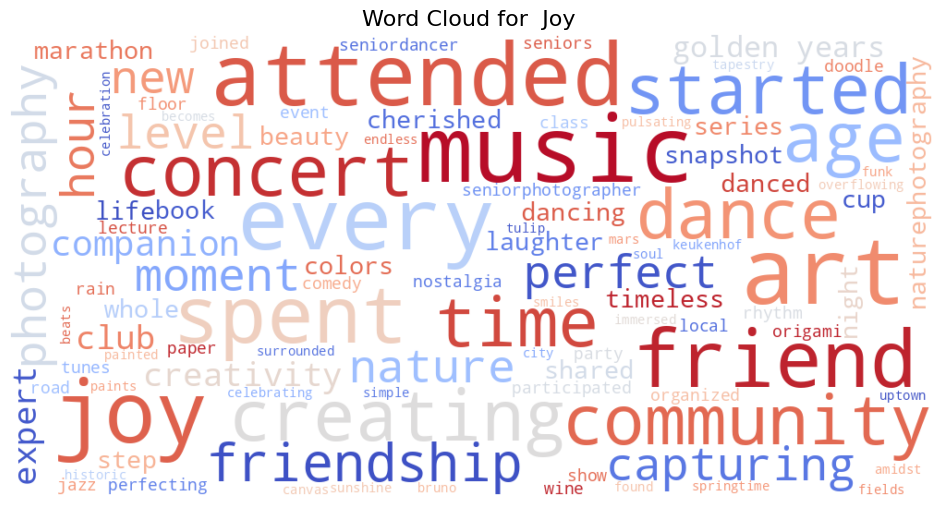

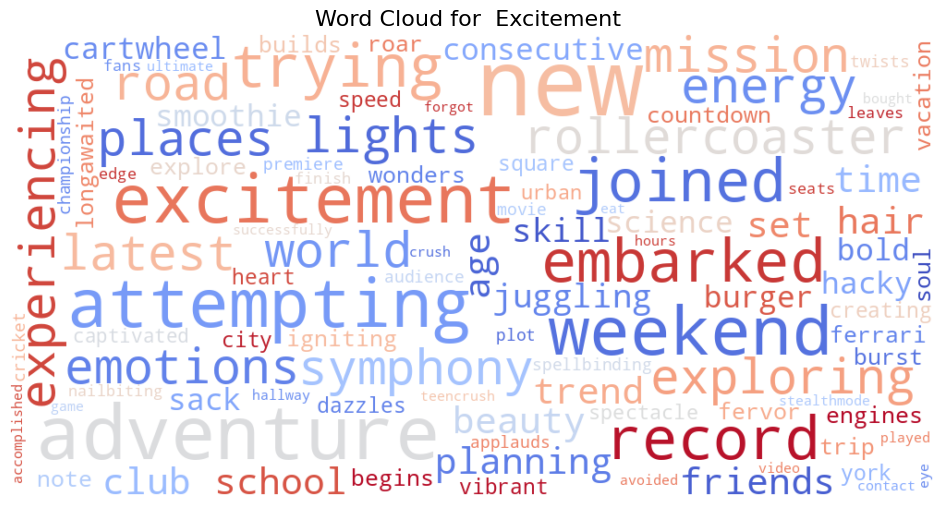

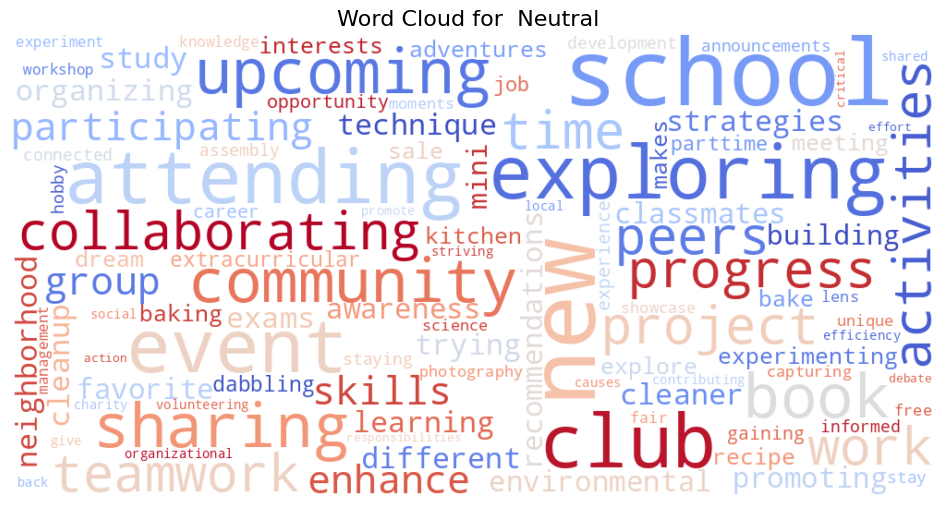

In [ ]:
# Step 2: Cleaned & Focused EDA

# ✅ Step 1: Limit to Top 4 Emotions
top_emotions = df['Sentiment'].value_counts().nlargest(4).index
df_top = df[df['Sentiment'].isin(top_emotions)].copy()

# ✅ Step 2: Extra stopwords cleanup for nicer word clouds
extra_stopwords = set(["im", "dont", "get", "got", "like", "would", "us"])
from nltk.corpus import stopwords
all_stopwords = set(stopwords.words('english')).union(extra_stopwords)

df_top['Clean_Text'] = df_top['Clean_Text'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in all_stopwords])
)

# ✅ Step 3: Better Count Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top, x='Sentiment', palette='Set2', order=top_emotions)
plt.title('Top 4 Emotion Distribution', fontsize=16)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ✅ Step 4: Box Plot for Text Length by Emotion
df_top['Text_Length'] = df_top['Clean_Text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_top, x='Sentiment', y='Text_Length', palette='Pastel1')
plt.title('Text Length by Emotion', fontsize=16)
plt.xlabel('Emotion')
plt.ylabel('Number of Words')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ✅ Step 5: Word Clouds for Each Emotion
from wordcloud import STOPWORDS, WordCloud

# Choose a color map (you can replace 'coolwarm' with other color maps such as 'Blues', 'Reds', etc.)
for emotion in top_emotions:
    text = " ".join(df_top[df_top['Sentiment'] == emotion]['Clean_Text'])
    wordcloud = WordCloud(
        width=1000,
        height=500,
        background_color='white',
        stopwords=STOPWORDS,
        colormap='coolwarm',  # Change colormap as desired
        max_words=100,
        max_font_size=100,
        min_font_size=10,
        prefer_horizontal=0.9,  # Make words more horizontal
        contour_width=3,
        contour_color='black'
    ).generate(text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {emotion}', fontsize=16)
    plt.show()


In [ ]:
# Step 3: Feature Engineering + TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# ✅ TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
X = tfidf.fit_transform(df_top['Clean_Text']).toarray()  # Input features
y = df_top['Encoded_Sentiment']  # Target labels (already encoded)

# ✅ Optional: Check shape
print("TF-IDF Matrix Shape:", X.shape)
print("Target Shape:", y.shape)

# ✅ Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training Set:", X_train.shape, y_train.shape)
print("Testing Set:", X_test.shape, y_test.shape)


TF-IDF Matrix Shape: (132, 695)
Target Shape: (132,)
Training Set: (105, 695) (105,)
Testing Set: (27, 695) (27,)


🔍 Logistic Regression Performance:
              precision    recall  f1-score   support

 Excitement        0.00      0.00      0.00         6
        Joy        0.50      0.67      0.57         9
    Neutral        0.00      0.00      0.00         3
  Positive         0.50      0.78      0.61         9

    accuracy                           0.48        27
   macro avg       0.25      0.36      0.30        27
weighted avg       0.33      0.48      0.39        27



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


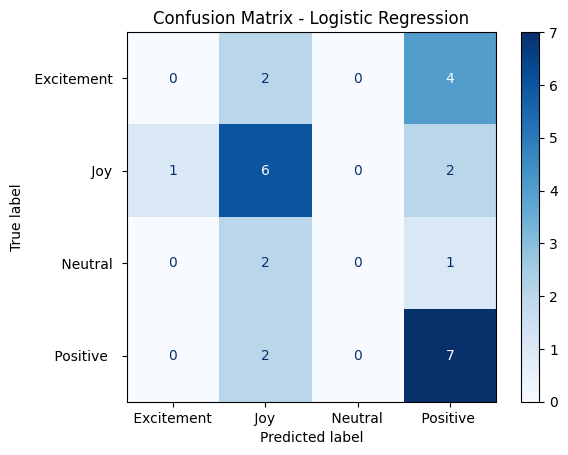

🔍 Naive Bayes Performance:
              precision    recall  f1-score   support

 Excitement        0.00      0.00      0.00         6
        Joy        0.67      0.44      0.53         9
    Neutral        0.00      0.00      0.00         3
  Positive         0.38      0.89      0.53         9

    accuracy                           0.44        27
   macro avg       0.26      0.33      0.27        27
weighted avg       0.35      0.44      0.36        27



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


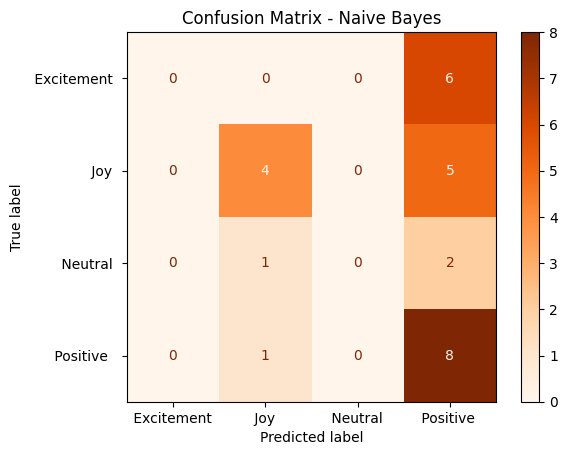

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Model 1: Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print("🔍 Logistic Regression Performance:")
print(classification_report(y_test, y_pred_log, target_names=label_encoder.inverse_transform(sorted(y.unique()))))

# Confusion Matrix - Logistic Regression
cm_log = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=label_encoder.inverse_transform(sorted(y.unique())))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# ✅ Model 2: Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("🔍 Naive Bayes Performance:")
print(classification_report(y_test, y_pred_nb, target_names=label_encoder.inverse_transform(sorted(y.unique()))))

# Confusion Matrix - Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=label_encoder.inverse_transform(sorted(y.unique())))
disp.plot(cmap='Oranges')
plt.title("Confusion Matrix - Naive Bayes")
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-9-3c8dbbd293eb>:30: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


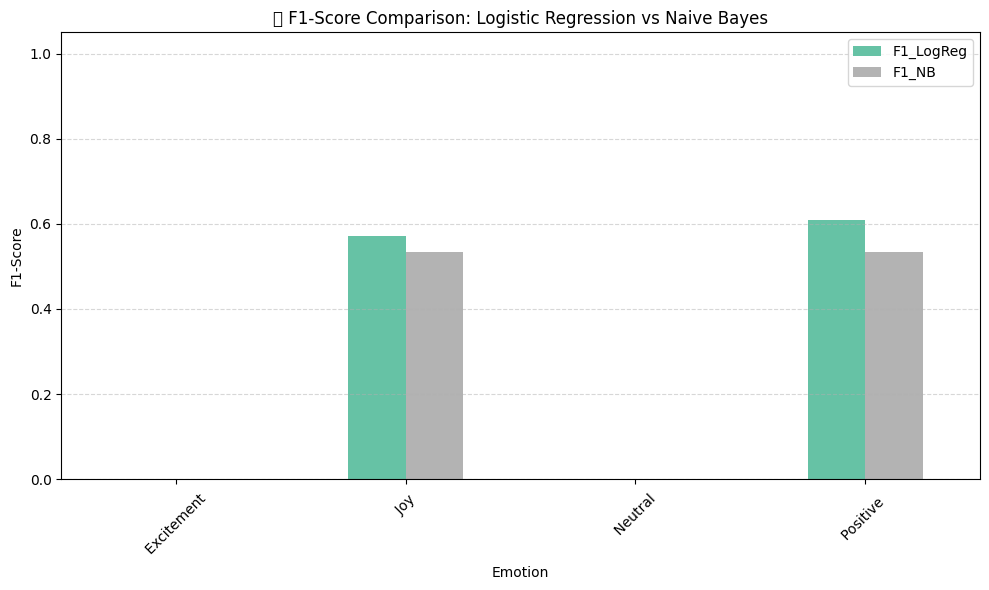

<ipython-input-9-3c8dbbd293eb>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values, y=top_words, palette='coolwarm')
<ipython-input-9-3c8dbbd293eb>:48: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


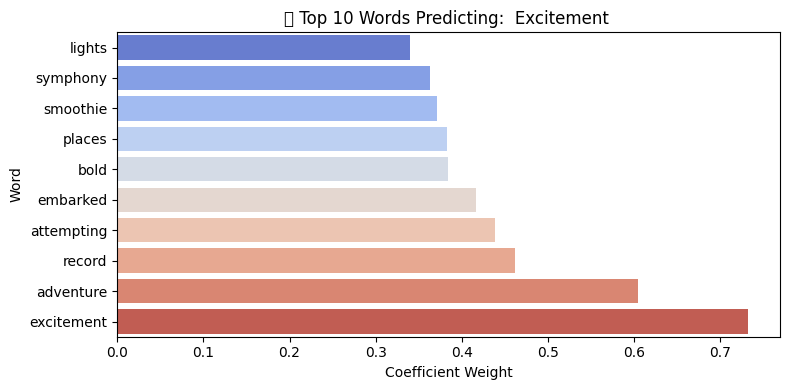

<ipython-input-9-3c8dbbd293eb>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values, y=top_words, palette='coolwarm')
<ipython-input-9-3c8dbbd293eb>:48: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


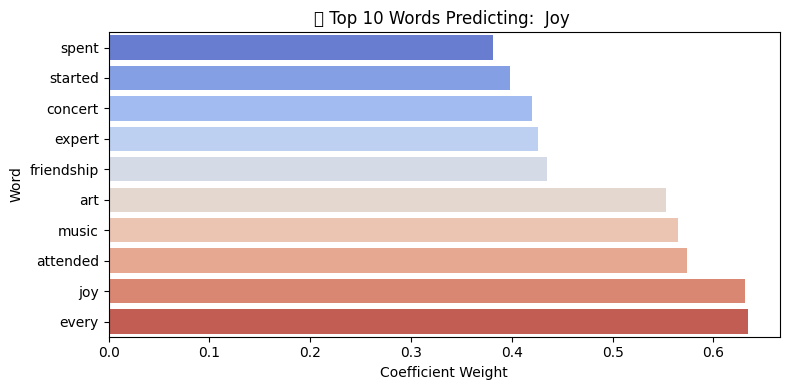

<ipython-input-9-3c8dbbd293eb>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values, y=top_words, palette='coolwarm')
<ipython-input-9-3c8dbbd293eb>:48: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


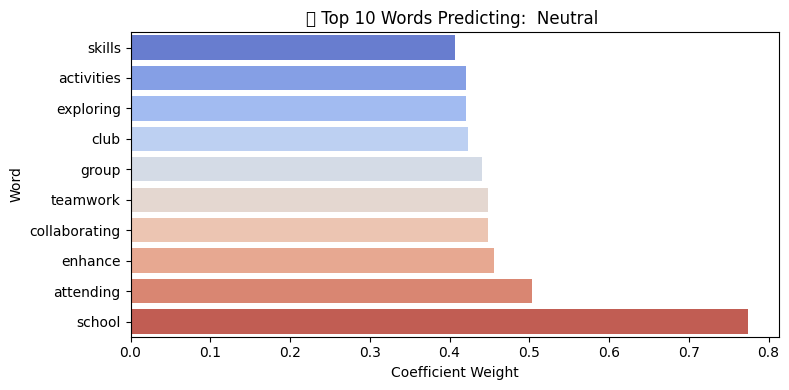

<ipython-input-9-3c8dbbd293eb>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values, y=top_words, palette='coolwarm')
<ipython-input-9-3c8dbbd293eb>:48: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


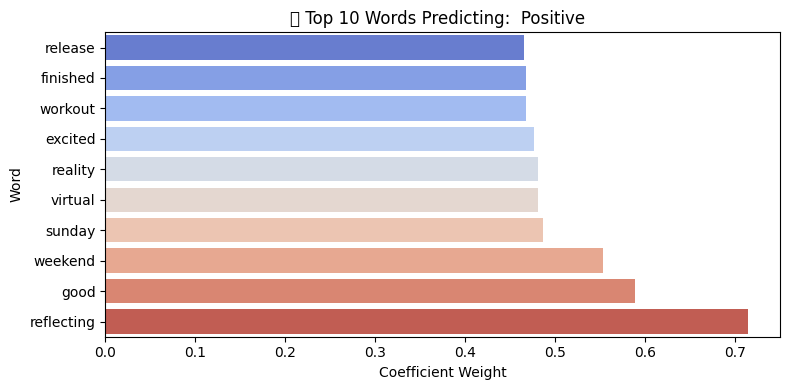

In [ ]:
import numpy as np

# ✅ Step 5A: Bar Chart Comparison of Metrics
from sklearn.metrics import precision_recall_fscore_support

# Get metrics
metrics_log = precision_recall_fscore_support(y_test, y_pred_log, average=None)
metrics_nb = precision_recall_fscore_support(y_test, y_pred_nb, average=None)
labels = label_encoder.inverse_transform(sorted(y.unique()))

# Prepare DataFrame
metrics_df = pd.DataFrame({
    'Emotion': labels,
    'Precision_LogReg': metrics_log[0],
    'Recall_LogReg': metrics_log[1],
    'F1_LogReg': metrics_log[2],
    'Precision_NB': metrics_nb[0],
    'Recall_NB': metrics_nb[1],
    'F1_NB': metrics_nb[2]
})

# Plotting
metrics_df.set_index('Emotion')[['F1_LogReg', 'F1_NB']].plot(kind='bar', figsize=(10,6), colormap='Set2')
plt.title("📊 F1-Score Comparison: Logistic Regression vs Naive Bayes")
plt.ylabel("F1-Score")
plt.xlabel("Emotion")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ✅ Step 5B: Most Important Words (Logistic Regression)
feature_names = tfidf.get_feature_names_out()
coefs = log_model.coef_

for idx, emotion in enumerate(labels):
    top_n = 10
    top_words_idx = np.argsort(coefs[idx])[-top_n:]
    top_words = feature_names[top_words_idx]
    top_values = coefs[idx][top_words_idx]

    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_values, y=top_words, palette='coolwarm')
    plt.title(f"🔍 Top {top_n} Words Predicting: {emotion}")
    plt.xlabel("Coefficient Weight")
    plt.ylabel("Word")
    plt.tight_layout()
    plt.show()
